In [ ]:
import pandas as pd
import platform
import keras
from collections import Counter
import os
import shutil
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import random
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
df = pd.read_csv('full_df.csv')  
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonproliferative re

In [1]:
print(platform.python_version())


3.11.4


In [2]:
print(keras.__version__)


3.4.1


In [2]:
label_counts = Counter()

for labels in df['labels']:
    for label in eval(labels):  # Use eval to convert string representation of list to actual list
        label_counts[label] += 1

# Print the number of images in each class
print("\nNumber of images in each class:")
for label, count in label_counts.items():
    print(f"{label}: {count}")


Number of images in each class:
N: 2873
D: 1608
O: 708
M: 232
H: 128
C: 293
A: 266
G: 284


In [3]:
# Load the DataFrame
df = pd.read_csv('full_df.csv')

# Define the file path to the actual images directory
actual_image_dir = 'preprocessed_images'
augmentation_dir = 'new_augmentation/'

# Delete the augmentation directory if it already exists
if os.path.exists(augmentation_dir):
    shutil.rmtree(augmentation_dir)

# Create the augmentation directory
os.makedirs(augmentation_dir)

# Initialize a counter for augmented images by class
class_counts = Counter()

# Filter the DataFrame for the specified classes
specified_classes = {'M', 'C', 'A', 'G'}
filtered_df = df[df['labels'].apply(lambda x: any(label in specified_classes for label in eval(x)))]

# Perform horizontal flip and save the images
augmented_data = []
for index, row in filtered_df.iterrows():
    filename = row['filename']
    
    # Load the image
    image_path = os.path.join(actual_image_dir, filename)
    if os.path.exists(image_path):
        image = Image.open(image_path)
        
        # Perform horizontal flip
        flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
        
        # Save the flipped image with the new naming convention
        flipped_image_filename = f"H-Flip_{filename}"
        flipped_image_path = os.path.join(augmentation_dir, flipped_image_filename)
        flipped_image.save(flipped_image_path)
        
        # Append the original row data with updated filename to the new DataFrame
        augmented_row = row.copy()
        augmented_row['filename'] = flipped_image_filename
        augmented_data.append(augmented_row)

        # Count the classes in the labels
        for label in eval(row['labels']):
            if label in specified_classes:
                class_counts[label] += 1

# Create a new DataFrame from the augmented data
augmented_df = pd.DataFrame(augmented_data)

# Save the augmented DataFrame to a new CSV file
augmented_df.to_csv('new_augmented_data.csv', index=False)

# Print class counts after augmentation
print("\nClass counts after augmentation:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

print("\nData augmentation complete and saved to 'new_augmented_data.csv'.")



Class counts after augmentation:
M: 232
C: 293
A: 266
G: 284

Data augmentation complete and saved to 'new_augmented_data.csv'.


In [4]:
pd.read_csv("new_augmented_data.csv")

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_13_right.jpg
1,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_16_right.jpg
2,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_18_right.jpg
3,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_24_right.jpg
4,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",H-Flip_43_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,2243,80,Male,2243_left.jpg,2243_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_2243_left.jpg
1071,2246,69,Male,2246_left.jpg,2246_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_2246_left.jpg
1072,2247,73,Male,2247_left.jpg,2247_right.jpg,cataract,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_2247_left.jpg
1073,2248,74,Female,2248_left.jpg,2248_right.jpg,cataract，lens dust,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_2248_left.jpg


In [5]:
# Load the original DataFrame
df = pd.read_csv('full_df.csv')

# Load the existing augmented DataFrame
augmented_df = pd.read_csv('new_augmented_data.csv')

# Define the file path to the actual images directory
actual_image_dir = 'preprocessed_images'
new_augmentation_dir = 'new_augmentation/'

# Initialize a counter for augmented images by class
class_counts_before = Counter()
class_counts_after = Counter()

# Filter the DataFrame for the specified classes
specified_classes = { 'M', 'C', 'A', 'G'}
filtered_df = df[df['labels'].apply(lambda x: any(label in specified_classes for label in eval(x)))]

# Count classes before augmentation
for labels in filtered_df['labels']:
    for label in eval(labels):
        if label in specified_classes:
            class_counts_before[label] += 1

# Print class counts before augmentation
print("Class counts before augmentation:")
for label, count in class_counts_before.items():
    print(f"{label}: {count}")

# List to store new rows for the augmented DataFrame
new_rows = []

# Perform vertical flip and save the images
for index, row in filtered_df.iterrows():
    filename = row['filename']
    
    # Load the image
    image_path = os.path.join(actual_image_dir, filename)
    if os.path.exists(image_path):
        image = Image.open(image_path)
        
        # Perform vertical flip
        flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)
        
        # Save the flipped image with the new naming convention
        flipped_image_filename = f"V-Flip_{filename}"
        flipped_image_path = os.path.join(new_augmentation_dir, flipped_image_filename)
        flipped_image.save(flipped_image_path)
        
        # Prepare the augmented row
        augmented_row = row.copy()
        augmented_row['filename'] = flipped_image_filename
        new_rows.append(augmented_row)

        # Count the classes in the labels
        for label in eval(row['labels']):
            if label in specified_classes:
                class_counts_after[label] += 1

# Convert new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the new rows to the existing DataFrame
augmented_df = pd.concat([augmented_df, new_rows_df], ignore_index=True)

# Save the updated DataFrame back to the same CSV file
augmented_df.to_csv('new_augmented_data.csv', index=False)

# Print class counts after augmentation
print("\nClass counts after vertical flip augmentation:")
for label, count in class_counts_after.items():
    print(f"{label}: {count}")

# Calculate total class counts in the updated augmented DataFrame
total_class_counts = Counter()
for labels in augmented_df['labels']:
    for label in eval(labels):
        total_class_counts[label] += 1

# Print total class counts in the updated augmented DataFrame
print("\nTotal number of images in each class in the updated augmented file:")
for label, count in total_class_counts.items():
    print(f"{label}: {count}")

print(f"\nTotal number of images in the updated augmented file: {len(augmented_df)}")
print("\nVertical flip data augmentation complete and appended to 'new_augmented_data.csv'.")


Class counts before augmentation:
M: 232
C: 293
A: 266
G: 284

Class counts after vertical flip augmentation:
M: 232
C: 293
A: 266
G: 284

Total number of images in each class in the updated augmented file:
M: 464
C: 586
A: 532
G: 568

Total number of images in the updated augmented file: 2150

Vertical flip data augmentation complete and appended to 'new_augmented_data.csv'.


In [6]:
pd.read_csv("new_augmented_data.csv")

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_13_right.jpg
1,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_16_right.jpg
2,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_18_right.jpg
3,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_24_right.jpg
4,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",H-Flip_43_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,2243,80,Male,2243_left.jpg,2243_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",V-Flip_2243_left.jpg
2146,2246,69,Male,2246_left.jpg,2246_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",V-Flip_2246_left.jpg
2147,2247,73,Male,2247_left.jpg,2247_right.jpg,cataract,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",V-Flip_2247_left.jpg
2148,2248,74,Female,2248_left.jpg,2248_right.jpg,cataract，lens dust,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",V-Flip_2248_left.jpg


In [7]:
# Load the original DataFrame
df = pd.read_csv('full_df.csv')

# Load the existing augmented DataFrame
augmented_df = pd.read_csv('new_augmented_data.csv')

# Define the file path to the actual images directory
actual_image_dir = 'preprocessed_images'
new_augmentation_dir = 'new_augmentation/'

# Initialize a counter for augmented images by class
class_counts_before = Counter()
class_counts_after = Counter()

# Filter the DataFrame for the specified classes
specified_classes = {'O', 'M', 'C', 'A', 'G'}
filtered_df = df[df['labels'].apply(lambda x: any(label in specified_classes for label in eval(x)))]

# Count classes before augmentation
for labels in filtered_df['labels']:
    for label in eval(labels):
        if label in specified_classes:
            class_counts_before[label] += 1

# Print class counts before augmentation
print("Class counts before augmentation:")
for label, count in class_counts_before.items():
    print(f"{label}: {count}")

# List to store new rows for the augmented DataFrame
new_rows = []

rotation_angle = 10  # Rotation by 10 degrees
for index, row in filtered_df.iterrows():
    filename = row['filename']
    
    # Load the image
    image_path = os.path.join(actual_image_dir, filename)
    if os.path.exists(image_path):
        image = Image.open(image_path)
        
        # Perform rotation
        rotated_image = image.rotate(rotation_angle)
        
        # Save the rotated image with the new naming convention
        rotated_image_filename = f"Rot{rotation_angle}_{filename}"
        rotated_image_path = os.path.join(new_augmentation_dir, rotated_image_filename)
        rotated_image.save(rotated_image_path)
        
        # Prepare the augmented row
        augmented_row = row.copy()
        augmented_row['filename'] = rotated_image_filename
        new_rows.append(augmented_row)

        # Count the classes in the labels
        for label in eval(row['labels']):
            if label in specified_classes:
                class_counts_after[label] += 1

# Convert new rows to a DataFrame
new_rows_df = pd.DataFrame(new_rows)

# Concatenate the new rows to the existing DataFrame
augmented_df = pd.concat([augmented_df, new_rows_df], ignore_index=True)

# Save the updated DataFrame back to the same CSV file
augmented_df.to_csv('new_augmented_data.csv', index=False)

# Print class counts after augmentation
print("\nClass counts after rotation augmentation:")
for label, count in class_counts_after.items():
    print(f"{label}: {count}")

# Calculate total class counts in the updated augmented DataFrame
total_class_counts = Counter()
for labels in augmented_df['labels']:
    for label in eval(labels):
        total_class_counts[label] += 1

# Print total class counts in the updated augmented DataFrame
print("\nTotal number of images in each class in the updated augmented file:")
for label, count in total_class_counts.items():
    print(f"{label}: {count}")

print(f"\nTotal number of images in the updated augmented file: {len(augmented_df)}")
print("\nRotation data augmentation complete and appended to 'new_augmented_data.csv'.")


Class counts before augmentation:
O: 708
M: 232
C: 293
A: 266
G: 284

Class counts after rotation augmentation:
O: 708
M: 232
C: 293
A: 266
G: 284

Total number of images in each class in the updated augmented file:
M: 696
C: 879
A: 798
G: 852
O: 708

Total number of images in the updated augmented file: 3933

Rotation data augmentation complete and appended to 'new_augmented_data.csv'.


In [8]:
pd.read_csv("new_augmented_data.csv")

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_13_right.jpg
1,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_16_right.jpg
2,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_18_right.jpg
3,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_24_right.jpg
4,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",H-Flip_43_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,2243,80,Male,2243_left.jpg,2243_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",Rot10_2243_left.jpg
3929,2246,69,Male,2246_left.jpg,2246_right.jpg,cataract,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",Rot10_2246_left.jpg
3930,2247,73,Male,2247_left.jpg,2247_right.jpg,cataract,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",Rot10_2247_left.jpg
3931,2248,74,Female,2248_left.jpg,2248_right.jpg,cataract，lens dust,cataract，lens dust,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",Rot10_2248_left.jpg


In [9]:
# Load the original dataset
original_df = pd.read_csv('full_df.csv')

# Load the augmented dataset
augmented_df = pd.read_csv('new_augmented_data.csv')

# Define the criteria for selecting original images
class_counts = {
    'C': original_df[original_df['labels'].apply(lambda x: 'C' in eval(x))],
    'M': original_df[original_df['labels'].apply(lambda x: 'M' in eval(x))],
    'A': original_df[original_df['labels'].apply(lambda x: 'A' in eval(x))],
    'G': original_df[original_df['labels'].apply(lambda x: 'G' in eval(x))],
    'N': original_df[original_df['labels'].apply(lambda x: 'N' in eval(x))].sample(frac=2/3, random_state=1),  # Two thirds of N
    'D': original_df[original_df['labels'].apply(lambda x: 'D' in eval(x))],   
    'O': original_df[original_df['labels'].apply(lambda x: 'O' in eval(x))]  # All of O
}

# Create a list to hold filtered images with their corresponding row data
filtered_rows = []

# Add images and their info from the augmented dataset
for _, row in augmented_df.iterrows():
    filtered_rows.append(row)

# Add images and their info for each specified class from the original dataset
for class_label, images in class_counts.items():
    for _, row in images.iterrows():
        filtered_rows.append(row)

# Create a new DataFrame for the filtered results
filtered_df = pd.DataFrame(filtered_rows)

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv('new_filtered_images.csv', index=False)

print("Filtered images saved to 'new_filtered_images.csv'.")


Filtered images saved to 'new_filtered_images.csv'.


In [10]:
pd.read_csv("filtered_images.csv")

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,13,60,Female,13_left.jpg,13_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_13_right.jpg
1,16,54,Female,16_left.jpg,16_right.jpg,normal fundus,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_16_right.jpg
2,18,58,Male,18_left.jpg,18_right.jpg,pathological myopia,pathological myopia,0,0,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['M'],"[0, 0, 0, 0, 0, 0, 1, 0]",H-Flip_18_right.jpg
3,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",H-Flip_24_right.jpg
4,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",H-Flip_43_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4982,4115,60,Male,4115_left.jpg,4115_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4115_left.jpg
4983,4361,62,Female,4361_left.jpg,4361_right.jpg,normal fundus,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4361_right.jpg
4984,4532,60,Male,4532_left.jpg,4532_right.jpg,mild nonproliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4532_left.jpg
4985,850,68,Male,850_left.jpg,850_right.jpg,moderate non proliferative retinopathy，macular...,macular epiretinal membrane，moderate non proli...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",850_left.jpg


In [11]:
# Load the filtered dataset
filtered_df = pd.read_csv('new_filtered_images.csv')

# Count the number of images in each class
class_counts = filtered_df['labels'].apply(eval).explode().value_counts()

# Print the counts for each class
print("Total number of images in each class:")
for label, count in class_counts.items():
    print(f"{label}: {count}")


Total number of images in each class:
N: 1915
D: 1608
O: 1416
C: 1172
G: 1136
A: 1064
M: 928


In [12]:
# Load the filtered dataset
filtered_df = pd.read_csv('new_filtered_images.csv')

# Verify the number of rows
print(f"Number of rows in new_filtered_images.csv: {len(filtered_df)}")

Number of rows in new_filtered_images.csv: 9239


In [15]:
# Load the filtered dataset
filtered_df = pd.read_csv('new_filtered_images.csv')

# Define directories
ORIGINAL_IMAGE_DIR = 'preprocessed_images'
AUGMENTATION_DIR = 'new_augmentation/'

# Define the desired image size
IMG_SIZE = (150, 150)  # Resize target to 150x150 pixels

# Prepare images and labels
images = []
labels = []

# Load images from the directories specified in the filtered dataset
for _, row in filtered_df.iterrows():
    img_path = os.path.join(ORIGINAL_IMAGE_DIR, row['filename'])
    if not os.path.exists(img_path):  # Check if the image is not in the original directory
        img_path = os.path.join(AUGMENTATION_DIR, row['filename'])  # Check in the augmentation directory

    if os.path.exists(img_path):
        img = Image.open(img_path).resize(IMG_SIZE)  # Resize the image here
        images.append(np.array(img))
        labels.append(eval(row['labels']))  # Get the list of labels

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# One-hot encode the labels
unique_labels = sorted(set(label for sublist in y for label in sublist))
label_to_index = {label: index for index, label in enumerate(unique_labels)}
y_encoded = np.array([[label_to_index[label] for label in labels] for labels in y])
y_categorical = to_categorical(y_encoded, num_classes=len(unique_labels))

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_categorical, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the total number of images for training, validation, and testing
print(f'Total images for training: {len(X_train)}')
print(f'Total images for validation: {len(X_val)}')
print(f'Total images for testing: {len(X_test)}')

# Verify the counts of images in each class for each set
def count_classes(y_data, unique_labels):
    counts = {label: 0 for label in unique_labels}
    for one_hot in y_data:
        for i, value in enumerate(one_hot):
            if value == 1:
                label = unique_labels[i]
                counts[label] += 1
    return counts

train_counts = count_classes(y_train, unique_labels)
val_counts = count_classes(y_val, unique_labels)
test_counts = count_classes(y_test, unique_labels)

print("\nClass counts in training set:")
for label, count in train_counts.items():
    print(f"{label}: {count}")

print("\nClass counts in validation set:")
for label, count in val_counts.items():
    print(f"{label}: {count}")

print("\nClass counts in testing set:")
for label, count in test_counts.items():
    print(f"{label}: {count}")


Total images for training: 5543
Total images for validation: 1848
Total images for testing: 1848

Class counts in training set:
A: 639
C: 666
D: 972
G: 697
M: 548
N: 1163
O: 858

Class counts in validation set:
A: 216
C: 260
D: 300
G: 223
M: 199
N: 356
O: 294

Class counts in testing set:
A: 209
C: 246
D: 336
G: 216
M: 181
N: 396
O: 264


In [17]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Load your dataset
filtered_df = pd.read_csv('new_filtered_images.csv')

# Define directories
ORIGINAL_IMAGE_DIR = 'preprocessed_images'
AUGMENTATION_DIR = 'new_augmentation/'
IMAGE_DIRS = [ORIGINAL_IMAGE_DIR, AUGMENTATION_DIR]  # List of image directories

# Define the desired image size
IMG_SIZE = (150, 150)

# Split the dataset
train_df, temp_df = train_test_split(filtered_df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# One-hot encode the labels
unique_labels = sorted(set(label for sublist in filtered_df['labels'].apply(eval) for label in sublist))
label_to_index = {label: index for index, label in enumerate(unique_labels)}

def one_hot_encode_labels(labels):
    encoded = np.zeros(len(unique_labels))
    for label in labels:
        encoded[label_to_index[label]] = 1
    return encoded

# Convert the one-hot encoded labels to strings for the generator
train_df['one_hot_labels'] = train_df['labels'].apply(eval).apply(lambda labels: str(one_hot_encode_labels(labels).tolist()))
val_df['one_hot_labels'] = val_df['labels'].apply(eval).apply(lambda labels: str(one_hot_encode_labels(labels).tolist()))
test_df['one_hot_labels'] = test_df['labels'].apply(eval).apply(lambda labels: str(one_hot_encode_labels(labels).tolist()))

# Data generators with rescaling
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Custom function to load images from multiple directories
def flow_from_dataframe_with_dirs(datagen, dataframe, image_dirs, image_size, batch_size, shuffle, class_mode):
    # Combine image directories into a single directory and assign a custom 'filename' column
    combined_df = dataframe.copy()
    combined_df['directory'] = np.random.choice(image_dirs, len(dataframe))
    combined_df['filepath'] = combined_df.apply(lambda row: os.path.join(row['directory'], row['filename']), axis=1)
    
    return datagen.flow_from_dataframe(
        dataframe=combined_df,
        directory=None,  # The directory is already included in the 'filepath' column
        x_col='filepath',
        y_col='one_hot_labels',
        target_size=image_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle
    )

# Create data generators
train_generator = flow_from_dataframe_with_dirs(
    datagen=train_datagen,
    dataframe=train_df,
    image_dirs=IMAGE_DIRS,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    class_mode='categorical'
)

val_generator = flow_from_dataframe_with_dirs(
    datagen=val_datagen,
    dataframe=val_df,
    image_dirs=IMAGE_DIRS,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

test_generator = flow_from_dataframe_with_dirs(
    datagen=test_datagen,
    dataframe=test_df,
    image_dirs=IMAGE_DIRS,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')


Found 2762 validated image filenames belonging to 7 classes.


C:\Users\Shahrukh\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2781 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 992 validated image filenames belonging to 7 classes.


C:\Users\Shahrukh\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 856 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(


Found 936 validated image filenames belonging to 7 classes.


C:\Users\Shahrukh\anaconda3\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 912 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  warnings.warn(




Epoch 1/30


86/86 [==============================] - 145s 2s/step - loss: 1.9283 - accuracy: 0.2121 - val_loss: 1.8497 - val_accuracy: 0.2167
Epoch 2/30
86/86 [==============================] - 83s 957ms/step - loss: 1.7894 - accuracy: 0.2850 - val_loss: 1.7293 - val_accuracy: 0.2974
Epoch 3/30
86/86 [==============================] - 82s 951ms/step - loss: 1.6932 - accuracy: 0.3275 - val_loss: 1.6536 - val_accuracy: 0.3216
Epoch 4/30
86/86 [==============================] - 82s 957ms/step - loss: 1.5834 - accuracy: 0.3729 - val_loss: 1.5048 - val_accuracy: 0.4073
Epoch 5/30
86/86 [==============================] - 83s 963ms/step - loss: 1.5115 - accuracy: 0.4128 - val_loss: 1.5020 - val_accuracy: 0.4163
Epoch 6/30
86/86 [==============================] - 84s 977ms/step - loss: 1.4354 - accuracy: 0.4509 - val_loss: 1.3910 - val_accuracy: 0.4395
Epoch 7/30
86/86 [==============================] - 82s 949ms/step - loss: 1.3656 - accuracy: 0.4663 - val_loss: 1.3675 - val_accuracy: 0.43

30/30 [==============================] - 8s 260ms/step


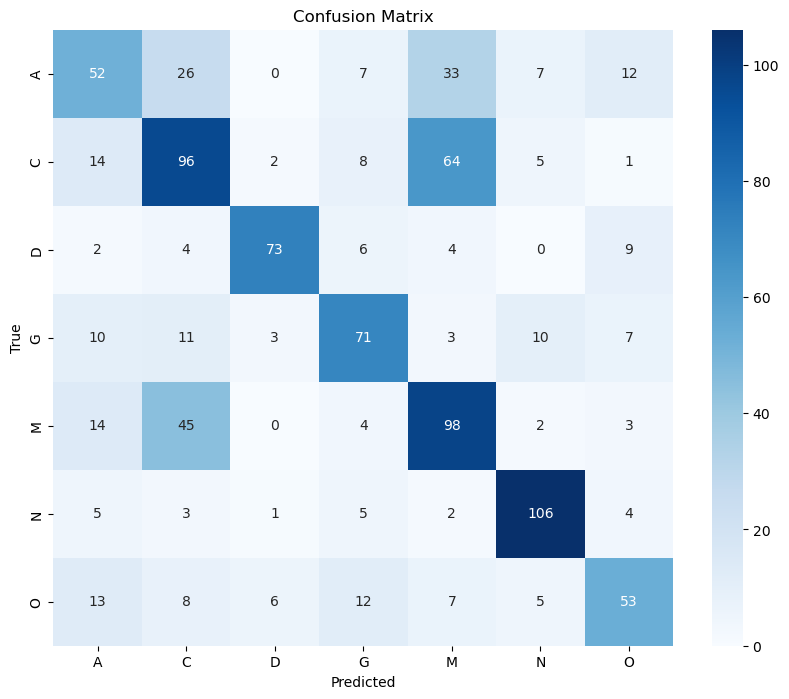

Classification Report:
              precision    recall  f1-score   support

           A       0.47      0.38      0.42       137
           C       0.50      0.51      0.50       190
           D       0.86      0.74      0.80        98
           G       0.63      0.62      0.62       115
           M       0.46      0.59      0.52       166
           N       0.79      0.84      0.81       126
           O       0.60      0.51      0.55       104

    accuracy                           0.59       936
   macro avg       0.61      0.60      0.60       936
weighted avg       0.59      0.59      0.59       936



In [18]:
# Predict on the test set
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=unique_labels))


In [ ]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')  # Adjust for number of classes
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="labels",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30
)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc}')


In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
test_generator = val_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')

# Predict on the test set
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes  

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_labels))

In [22]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(unique_labels), activation='softmax')  
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Create ImageDataGenerators without augmentation
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32,
    epochs=30
)

# Evaluate the model on the test set
test_generator = val_datagen.flow(X_test, y_test, batch_size=32)
test_loss, test_acc = model.evaluate(test_generator, steps=len(X_test) // 32)
print(f'Test accuracy: {test_acc}')

Epoch 1/30
93/93 [==============================] - 516s 5s/step - loss: 1.7933 - accuracy: 0.2557 - val_loss: 1.6299 - val_accuracy: 0.3206
Epoch 2/30
93/93 [==============================] - 272s 3s/step - loss: 1.6269 - accuracy: 0.3277 - val_loss: 1.5581 - val_accuracy: 0.3831
Epoch 3/30
93/93 [==============================] - 224s 2s/step - loss: 1.5405 - accuracy: 0.3632 - val_loss: 1.4381 - val_accuracy: 0.4315
Epoch 4/30
93/93 [==============================] - 211s 2s/step - loss: 1.4565 - accuracy: 0.4182 - val_loss: 1.3743 - val_accuracy: 0.4385
Epoch 5/30
93/93 [==============================] - 205s 2s/step - loss: 1.3294 - accuracy: 0.4666 - val_loss: 1.3142 - val_accuracy: 0.4859
Epoch 6/30
93/93 [==============================] - 266s 3s/step - loss: 1.2845 - accuracy: 0.4760 - val_loss: 1.2387 - val_accuracy: 0.5121
Epoch 7/30
93/93 [==============================] - 278s 3s/step - loss: 1.2248 - accuracy: 0.5017 - val_loss: 1.1504 - val_accuracy: 0.5343
Epoch 8/30
93

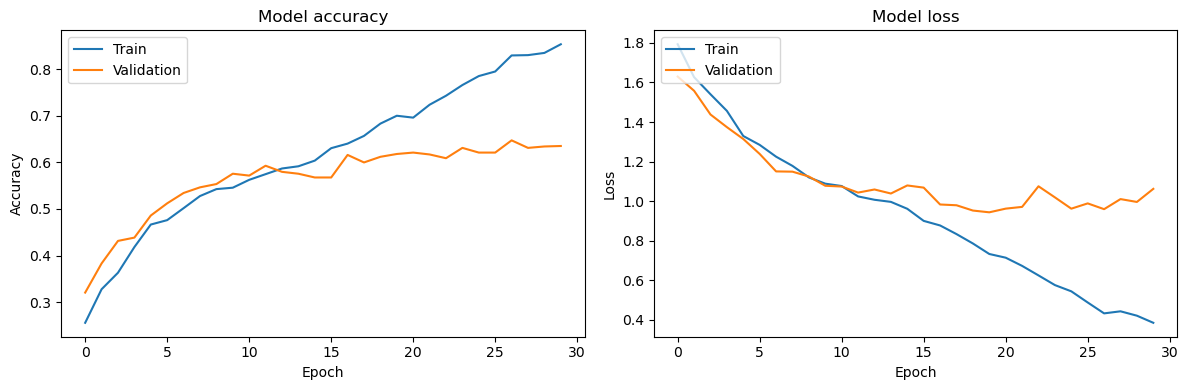

In [23]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

32/32 [==============================] - 36s 1s/step - loss: 1.0496 - accuracy: 0.6323
Test accuracy: 0.6322645545005798
32/32 [==============================] - 22s 281ms/step


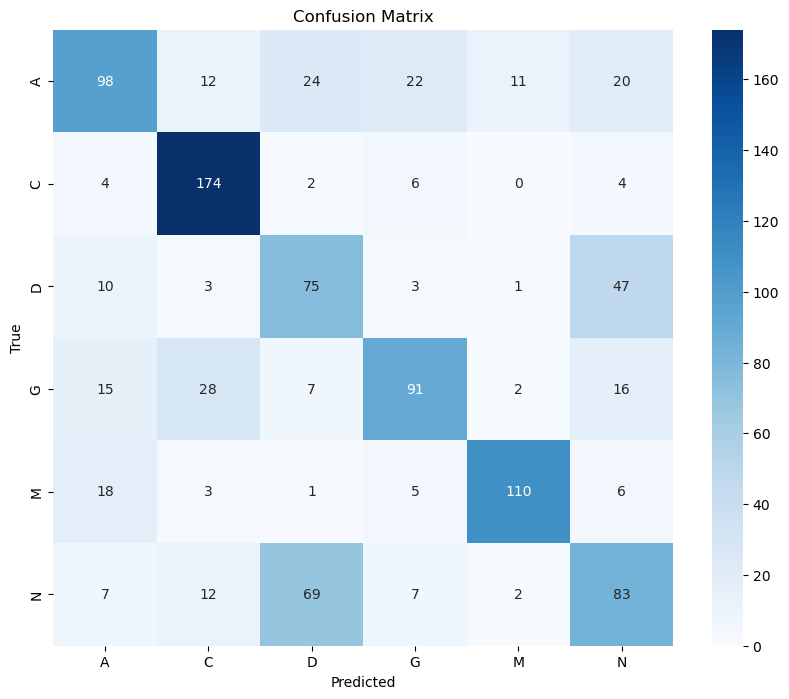

Classification Report:
              precision    recall  f1-score   support

           A       0.64      0.52      0.58       187
           C       0.75      0.92      0.82       190
           D       0.42      0.54      0.47       139
           G       0.68      0.57      0.62       159
           M       0.87      0.77      0.82       143
           N       0.47      0.46      0.47       180

    accuracy                           0.63       998
   macro avg       0.64      0.63      0.63       998
weighted avg       0.64      0.63      0.63       998



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
test_generator = val_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_acc}')

# Predict on the test set
y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test[:len(y_pred_classes)], axis=1)  # Match the length of y_pred_classes

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=unique_labels))